# Dual-Echo Denoising with `nilearn`

Dual-echo fMRI leverages one of the same principles motivating multi-echo fMRI; namely, that BOLD contrast increases with echo time, so earlier echoes tend to be more affected by non-BOLD noise than later ones. At an early enough echo time (<5ms for 3T scanners), the signal is almost entirely driven by non-BOLD noise. When it comes to denoising, this means that, if you acquire data with both an early echo time and a more typical echo time (~30ms for 3T), you can simply regress the earlier echo's time series out of the later echo's time series, which will remove a lot of non-BOLD noise.

Additionally, dual-echo fMRI comes at no real cost in terms of temporal or spatial resolution, unlike multi-echo fMRI. For multi-echo denoising to work, you need to have at least one echo time that is _later_ than the typical echo time, which means decreasing your temporal resolution, all else remaining equal. In the case of dual-echo fMRI, you only need a _shorter_ echo time, which occurs in what is essentially "dead time" in the pulse sequence.

Dual-echo denoising was originally proposed in [Bright & Murphy (2013)](https://dx.doi.org/10.1016%2Fj.neuroimage.2012.09.043).

In [1]:
import os

from myst_nb import glue
import matplotlib.pyplot as plt
import numpy as np
from nilearn import image, masking, plotting

from repo2data.repo2data import Repo2Data

# Install the data if running locally, or points to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.abspath(os.path.join(data_path[0], "data"))


def regress_one_image_out_of_another(data_img, nuis_img, mask_img):
    # First, mean-center each image over time
    mean_data_img = image.mean_img(data_img)
    mean_nuis_img = image.mean_img(nuis_img)

    data_img_mc = image.math_img(
        "img - avg_img[..., None]",
        img=data_img,
        avg_img=mean_data_img,
    )
    nuis_img_mc = image.math_img(
        "img - avg_img[..., None]",
        img=nuis_img,
        avg_img=mean_nuis_img,
    )

    # Now get the masked data in 2D format
    data_mc = masking.apply_mask(data_img_mc, mask_img)
    nuis_mc = masking.apply_mask(nuis_img_mc, mask_img)
    nuis_mean = masking.apply_mask(mean_nuis_img, mask_img)
    data_mean = masking.apply_mask(mean_data_img, mask_img)

    # Build beta map by performing regression on each voxel
    betas = np.zeros(data_mc.shape[1])
    for i_voxel in range(data_mc.shape[1]):
        temp_data = np.stack((data_mc[:, i_voxel], np.ones(data_mc.shape[0])), -1)
        betas = np.linalg.lstsq(temp_data, nuis_mc[:, i_voxel], rcond=None)[0][0]

    # Construct denoised time series
    scaled_nuis = (nuis_mc * betas)
    errorts = (data_mc - scaled_nuis) + data_mean
    errorts_img = masking.unmask(errorts, mask_img)

    return errorts_img

---- repo2data starting ----
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/multi-echo-data-analysis

Info : ./../data/multi-echo-data-analysis already downloaded


/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
te1_img = os.path.join(data_path, "sub-04570/func/sub-04570_task-rest_echo-1_space-scanner_desc-partialPreproc_bold.nii.gz")
te2_img = os.path.join(data_path, "sub-04570/func/sub-04570_task-rest_echo-2_space-scanner_desc-partialPreproc_bold.nii.gz")
mask_img = os.path.join(data_path, "sub-04570/func/sub-04570_task-rest_space-scanner_desc-brain_mask.nii.gz")
denoised_img = regress_one_image_out_of_another(te2_img, te1_img, mask_img)

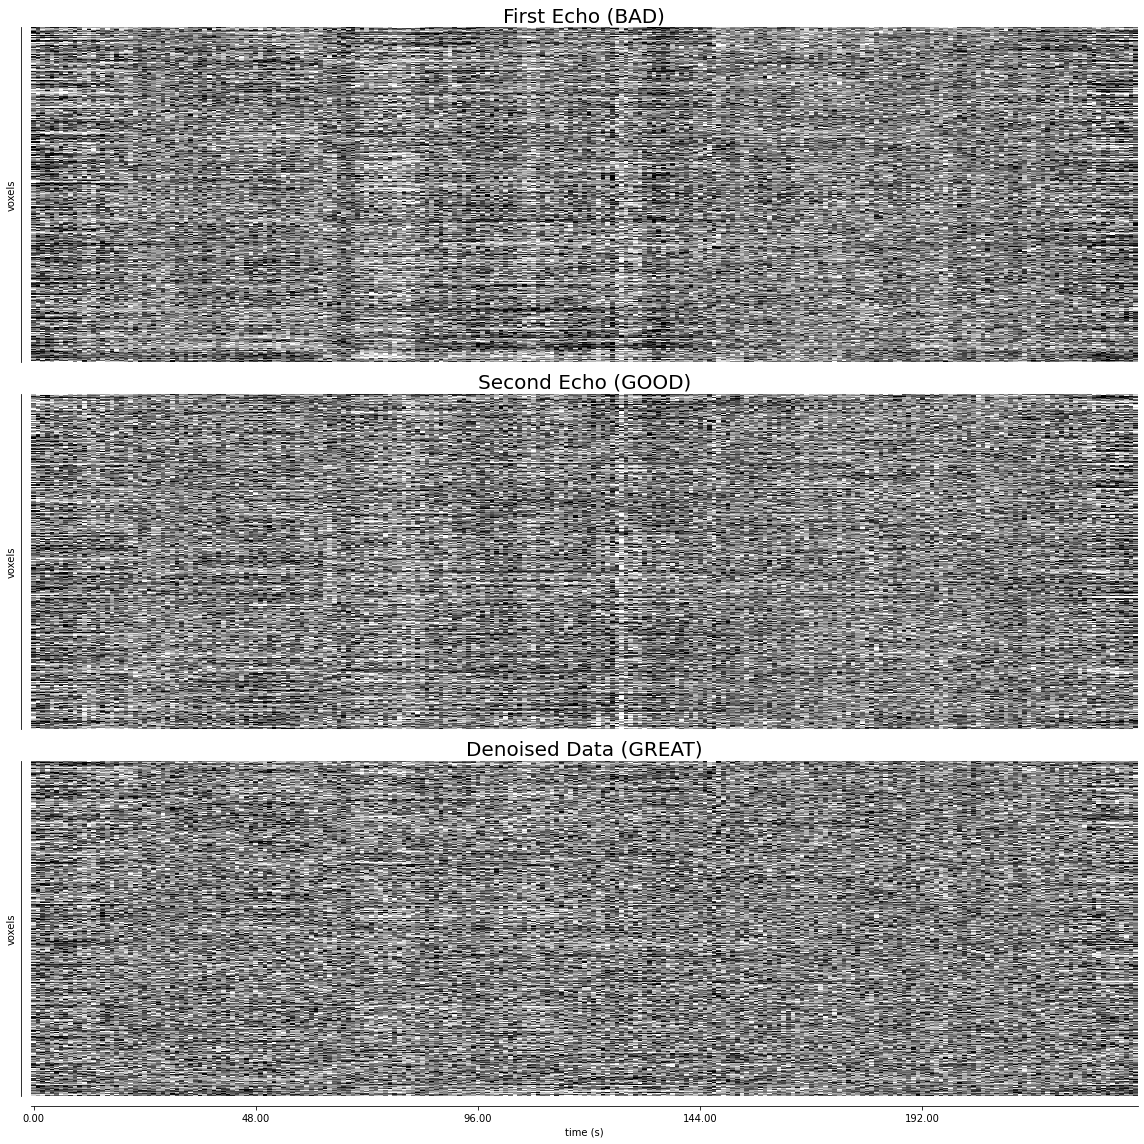

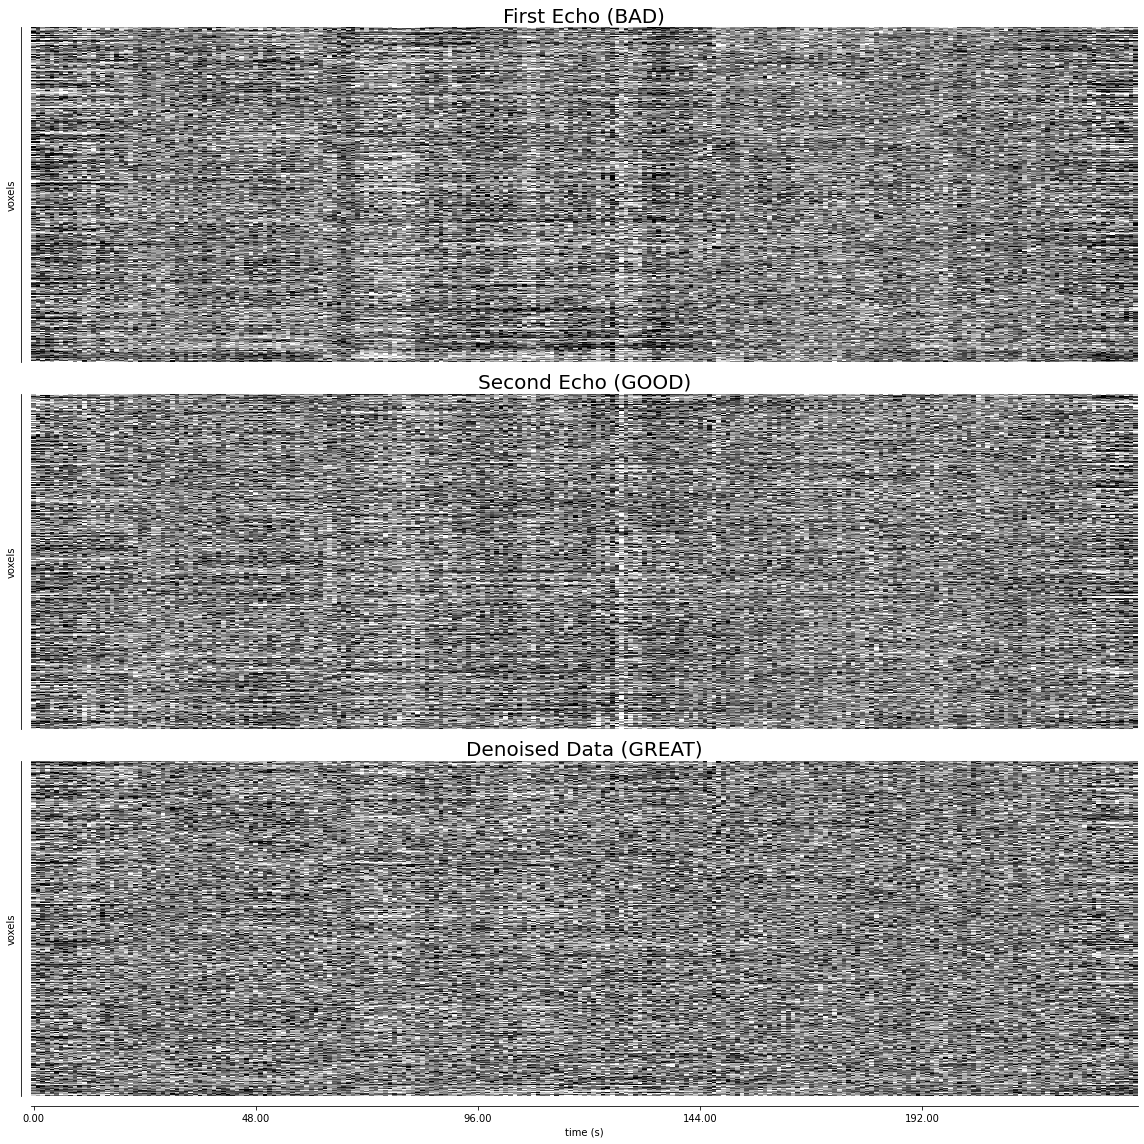

In [3]:
fig, axes = plt.subplots(figsize=(16, 16), nrows=3)

plotting.plot_carpet(te2_img, axes=axes[0], figure=fig)
axes[0].set_title("First Echo (BAD)", fontsize=20)
plotting.plot_carpet(te1_img, axes=axes[1], figure=fig)
axes[1].set_title("Second Echo (GOOD)", fontsize=20)
plotting.plot_carpet(denoised_img, axes=axes[2], figure=fig)
axes[2].set_title("Denoised Data (GREAT)", fontsize=20)
axes[0].xaxis.set_visible(False)
axes[1].xaxis.set_visible(False)
axes[0].spines["bottom"].set_visible(False)
axes[1].spines["bottom"].set_visible(False)
fig.tight_layout()
glue("figure_dual_echo_results", fig, display=False)

```{glue:figure} figure_dual_echo_results
:name: "figure_dual_echo_results"
:align: center

Results of dual-echo regression.
```